In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import joblib

from src.config import (
    MASTER_DF_FILE,
    RANDOM_SEED,
    MODELS_DIR,
    MUNICIPALITY_COLUMN,
    WEATHER_COLUMNS,
    SERVICES_COLUMNS,
    AGE_COLUMNS,
    INCOME_COLUMN,
    POP_DENSITY_COLUMN,
    URBAN_CLUSTER_FILE
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
df_master = pd.read_csv(URBAN_CLUSTER_FILE)
target_column = "log_price_sqm"

numerical_features = WEATHER_COLUMNS + SERVICES_COLUMNS + [INCOME_COLUMN, POP_DENSITY_COLUMN]
categorical_features = AGE_COLUMNS + ["cluster_urban"]
feature_cols = numerical_features + categorical_features

X = df_master[feature_cols].copy()
y = df_master[target_column].copy()
groups = df_master[MUNICIPALITY_COLUMN].values

valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx].reset_index(drop=True)
y = y[valid_idx].reset_index(drop=True)
groups = groups[valid_idx]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", "passthrough", categorical_features),
    ],
    remainder="drop",
)

In [60]:
model_configs = {
    "linear": {"class": LinearRegression, "params": {}},
    "ridge": {"class": Ridge, "params": {"alpha": 1.0, "random_state": RANDOM_SEED}},
    "lasso": {"class": Lasso, "params": {"alpha": 0.1, "random_state": RANDOM_SEED, "max_iter": 5000}},
    "elasticnet": {"class": ElasticNet, "params": {"alpha": 0.1, "l1_ratio": 0.5, "random_state": RANDOM_SEED, "max_iter": 5000}},
    "gbm": {"class": GradientBoostingRegressor, "params": {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.1, "random_state": RANDOM_SEED, "subsample": 0.8, "max_features": "sqrt"}},
}

In [61]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

cv_results = {}
trained_pipelines = {}

scoring = {"r2": "r2", "neg_mse": "neg_mean_squared_error", "neg_mae": "neg_mean_absolute_error"}

for model_key, config in model_configs.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", config["class"](**config["params"])),
    ])
    
    cv_scores = cross_validate(pipeline, X, y, cv=gkf, groups=groups, scoring=scoring, return_train_score=True, n_jobs=-1)
    cv_results[model_key] = cv_scores
    
    pipeline.fit(X, y)
    trained_pipelines[model_key] = pipeline

In [62]:
results_summary = []

for model_key in cv_results.keys():
    scores = cv_results[model_key]
    test_r2 = scores["test_r2"]
    test_rmse = np.sqrt(-scores["test_neg_mse"])
    test_mae = -scores["test_neg_mae"]
    train_r2 = scores["train_r2"]
    
    results_summary.append({
        "Model": model_key,
        "Test R²": test_r2.mean(),
        "Test R² (std)": test_r2.std(),
        "Test RMSE": test_rmse.mean(),
        "Test MAE": test_mae.mean(),
        "Train R²": train_r2.mean(),
        "Overfit Gap": train_r2.mean() - test_r2.mean(),
    })

results_df = pd.DataFrame(results_summary).sort_values("Test R²", ascending=False).reset_index(drop=True)
display(results_df.round(4))

,Model,Test R²,Test R² (std),Test RMSE,Test MAE,Train R²,Overfit Gap
0,gbm,0.6179,0.0892,0.3432,0.2604,0.9568,0.3389
1,elasticnet,0.3483,0.1006,0.4513,0.3371,0.4513,0.1029
2,ridge,0.2878,0.1271,0.4707,0.3528,0.5592,0.2714
3,lasso,0.2741,0.1243,0.4761,0.3560,0.3877,0.1136
4,linear,-0.0340,0.5789,0.5492,0.3831,0.5594,0.5934


In [63]:
feature_names = numerical_features + categorical_features
feature_importance_data = {}

for model_key, pipeline in trained_pipelines.items():
    regressor = pipeline.named_steps["regressor"]
    
    if hasattr(regressor, "coef_"):
        importances = regressor.coef_
        col_name = "Coefficient"
    elif hasattr(regressor, "feature_importances_"):
        importances = regressor.feature_importances_
        col_name = "Importance"
    else:
        continue
    
    feature_importance_data[model_key] = pd.DataFrame({
        "Feature": feature_names,
        col_name: importances
    }).sort_values(by=col_name, key=abs, ascending=False)

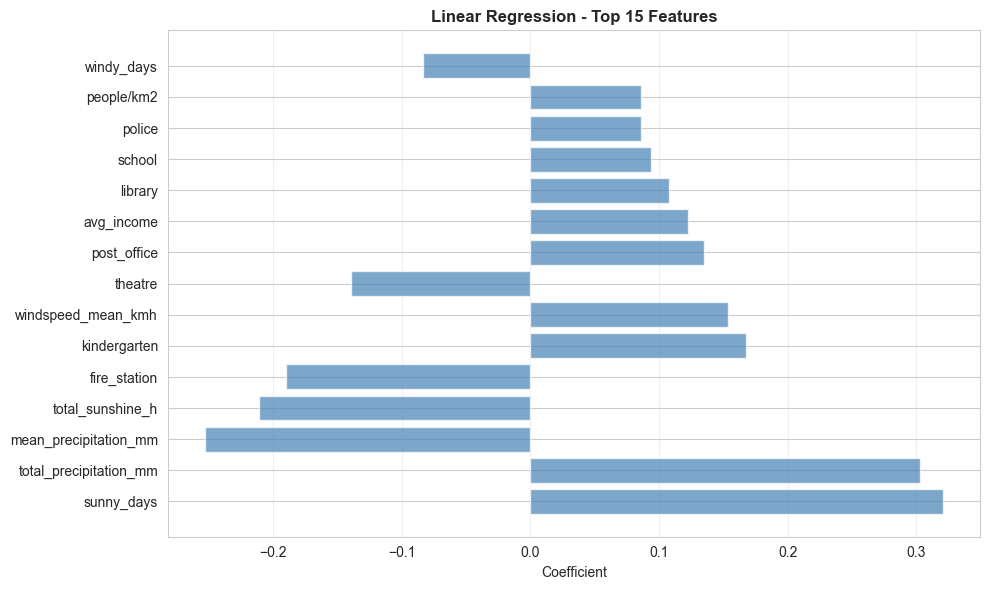

In [64]:
df = feature_importance_data["linear"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Linear Regression - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [65]:
df = feature_importance_data["linear"].head(15)
display(df.round(4))

,Feature,Coefficient
7,sunny_days,0.3207
3,total_precipitation_mm,0.3031
4,mean_precipitation_mm,-0.2530
0,total_sunshine_h,-0.2106
12,fire_station,-0.1898
14,kindergarten,0.1674
2,windspeed_mean_kmh,0.1535
23,theatre,-0.1397
20,post_office,0.1353
25,avg_income,0.1222


## Ridge Regression

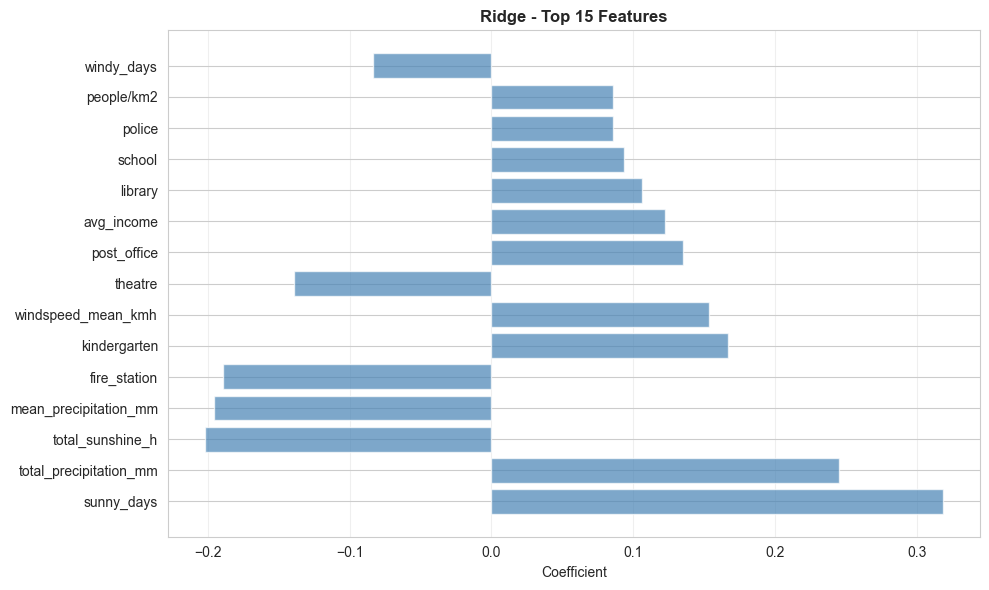

In [66]:
df = feature_importance_data["ridge"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Ridge - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [67]:
df = feature_importance_data["ridge"].head(15)
display(df.round(4))

,Feature,Coefficient
7,sunny_days,0.3184
3,total_precipitation_mm,0.2449
0,total_sunshine_h,-0.2021
4,mean_precipitation_mm,-0.1953
12,fire_station,-0.1890
14,kindergarten,0.1664
2,windspeed_mean_kmh,0.1534
23,theatre,-0.1389
20,post_office,0.1349
25,avg_income,0.1222


## Lasso Regression

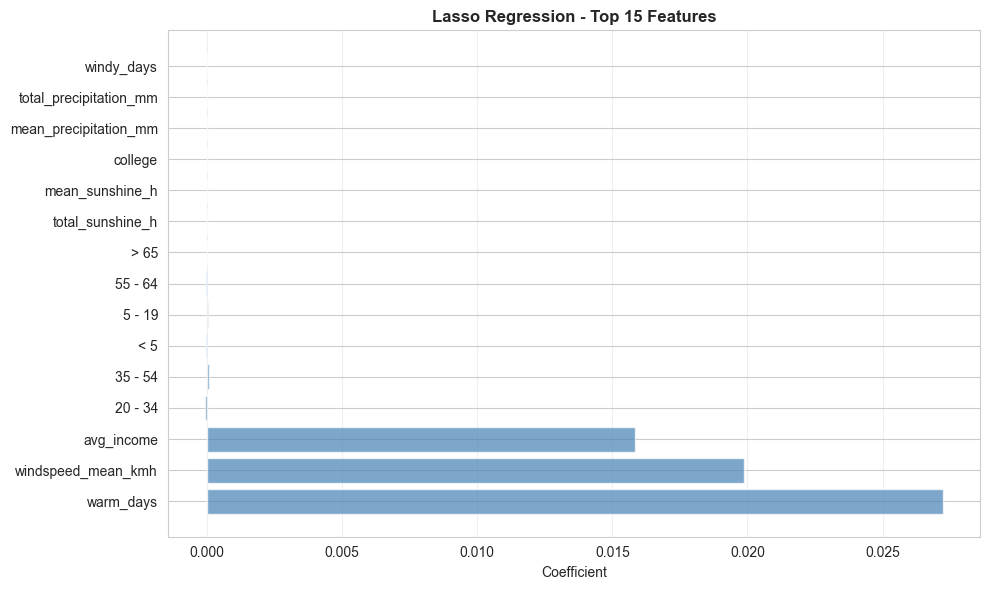

In [68]:
df = feature_importance_data["lasso"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Lasso Regression - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [69]:
df = feature_importance_data["lasso"].head(15)
display(df.round(4))

,Feature,Coefficient
8,warm_days,0.0272
2,windspeed_mean_kmh,0.0199
25,avg_income,0.0158
29,20 - 34,-0.0001
30,35 - 54,0.0001
27,< 5,-0.0001
28,5 - 19,0.0000
31,55 - 64,-0.0000
32,> 65,0.0000
0,total_sunshine_h,0.0000


## ElasticNet

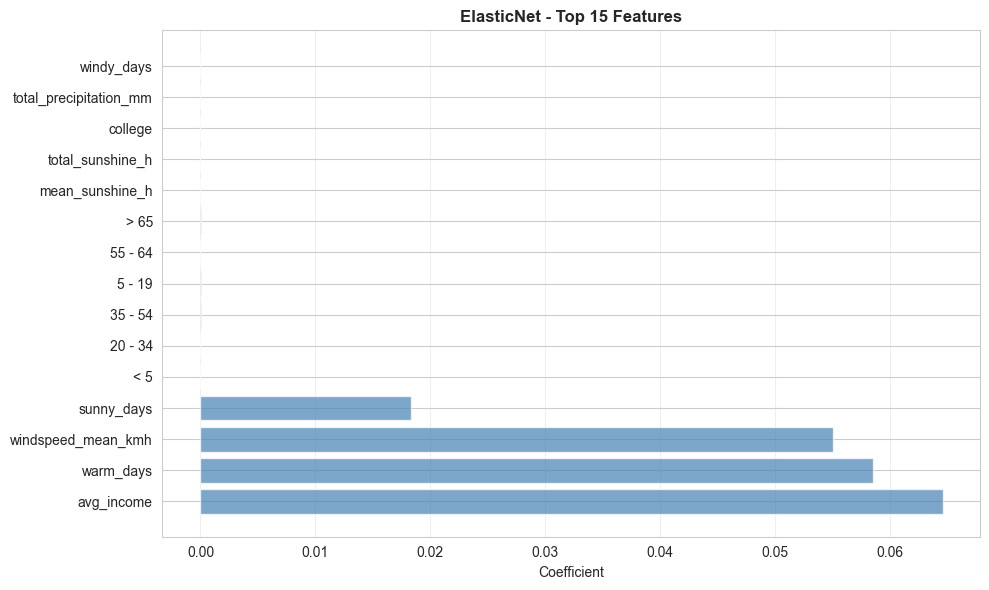

In [70]:
df = feature_importance_data["elasticnet"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("ElasticNet - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [71]:
df = feature_importance_data["elasticnet"].head(15)
display(df.round(4))

,Feature,Coefficient
25,avg_income,0.0646
8,warm_days,0.0585
2,windspeed_mean_kmh,0.0551
7,sunny_days,0.0184
27,< 5,-0.0001
29,20 - 34,-0.0001
30,35 - 54,0.0001
28,5 - 19,0.0000
31,55 - 64,-0.0000
32,> 65,0.0000


## Gradient Boosting

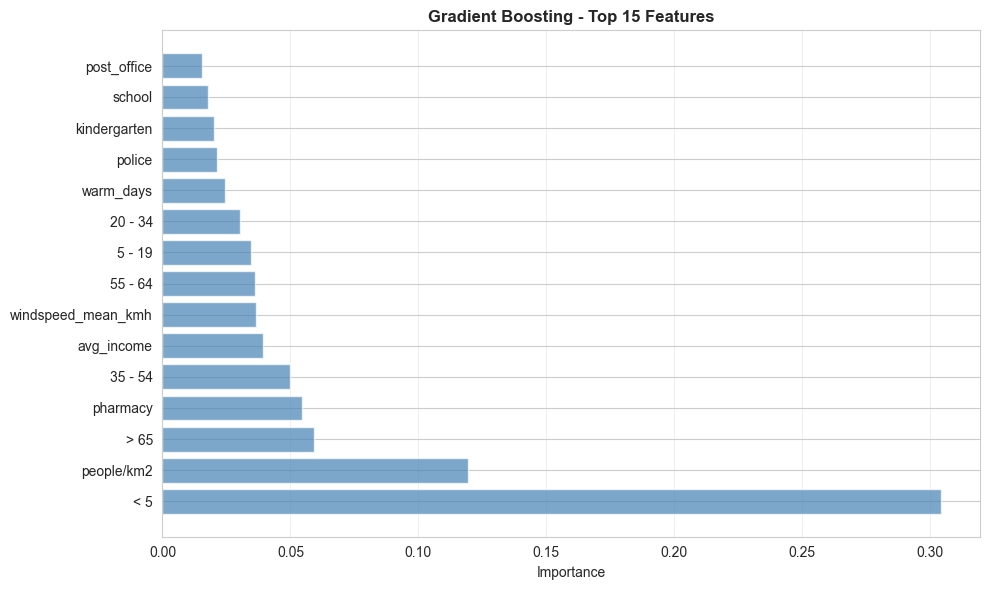

In [72]:
df = feature_importance_data["gbm"].head(15)
col_name = "Importance"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Gradient Boosting - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [73]:
df = feature_importance_data["gbm"].head(15)
display(df.round(4))

,Feature,Importance
27,< 5,0.3043
26,people/km2,0.1195
32,> 65,0.0590
18,pharmacy,0.0546
30,35 - 54,0.0498
25,avg_income,0.0394
2,windspeed_mean_kmh,0.0366
31,55 - 64,0.0362
28,5 - 19,0.0346
29,20 - 34,0.0304


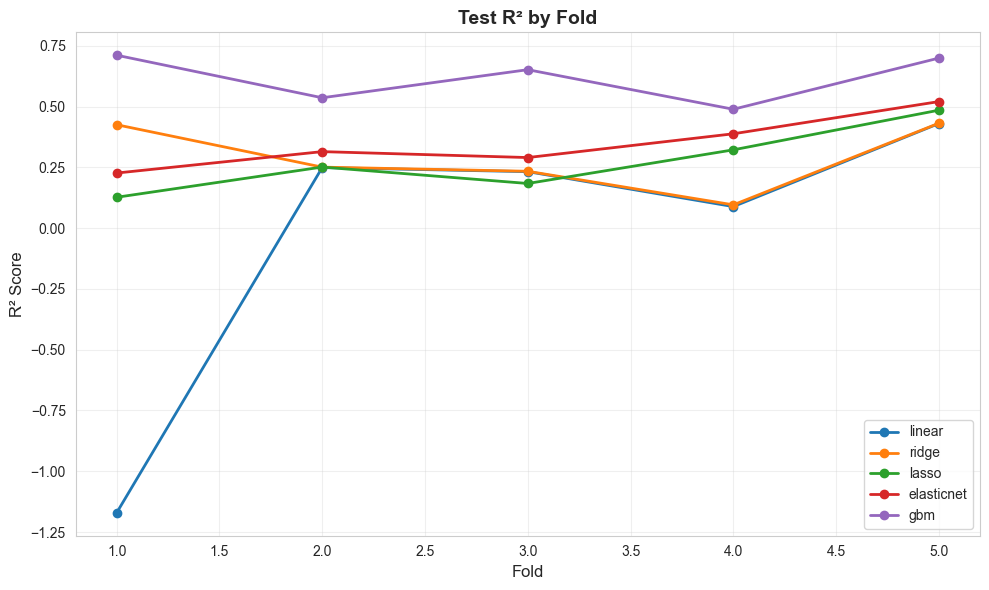

In [74]:
plt.figure(figsize=(10, 6))

for model_key in cv_results.keys():
    test_r2 = cv_results[model_key]["test_r2"]
    plt.plot(range(1, n_splits + 1), test_r2, marker='o', label=model_key, linewidth=2)

plt.xlabel("Fold", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("Test R² by Fold", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [75]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)

best_model_key = results_df.iloc[0]["Model"]
final_pipeline = trained_pipelines[best_model_key]

model_path = MODELS_DIR / f"{best_model_key}_final_model.joblib"
joblib.dump(final_pipeline, model_path)

results_path = MODELS_DIR / "cv_results.csv"
results_df.to_csv(results_path, index=False)


In [76]:
best_model_key = results_df.iloc[0]["Model"]
best_pipeline = trained_pipelines[best_model_key]

y_pred = best_pipeline.predict(X)
residuals = y - y_pred

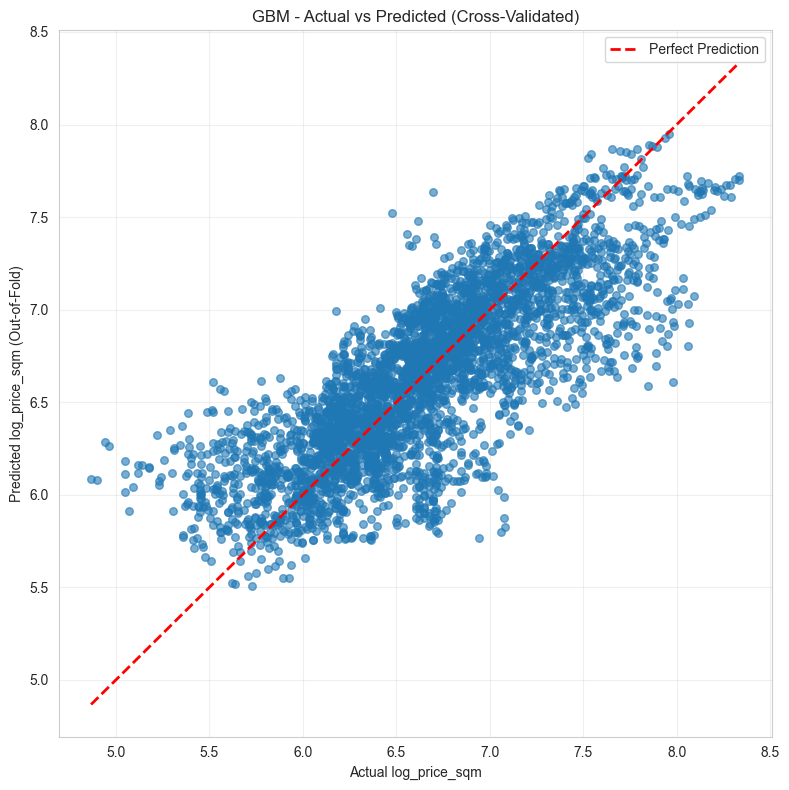

Out-of-Fold Performance (True Test Performance):
  R²: 0.6302
  RMSE: 0.3446
  MAE: 0.2604


In [ ]:
best_model_key = results_df.iloc[0]["Model"]
best_config = model_configs[best_model_key]

best_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_config["class"](**best_config["params"])),
])

y_pred_cv = cross_val_predict(best_pipeline, X, y, cv=gkf, groups=groups, n_jobs=-1)

plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_cv, alpha=0.6, s=30)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual log_price_sqm')
plt.ylabel('Predicted log_price_sqm (Out-of-Fold)')
plt.title(f'{best_model_key.upper()} - Actual vs Predicted (Cross-Validated)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Out-of-Fold Performance (True Test Performance):")
print(f"  R²: {r2_score(y, y_pred_cv):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y, y_pred_cv)):.4f}")
print(f"  MAE: {mean_absolute_error(y, y_pred_cv):.4f}")